# Imports

In [2]:
using Distributed
using MAT
using Plots
using Images

include("./unmixing_optimization/main.jl");

# Data Visualization

In [3]:
pyplot()
filename = "../project_data.mat"
file = matopen(filename)
img = read(file, "im")
sources = read(file,"sources")
rgb = read(file,"rgb")
close(file);

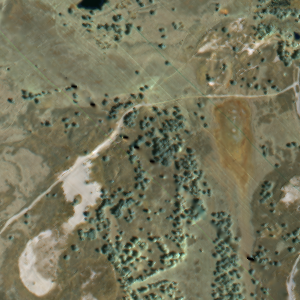

In [4]:
# Visualize data in rgb (using bands 67,109,141 as th RGB channels)
p1 = colorview(RGB, permutedims(rgb,(3,1,2))) # convert 3d array to the image format used by julia

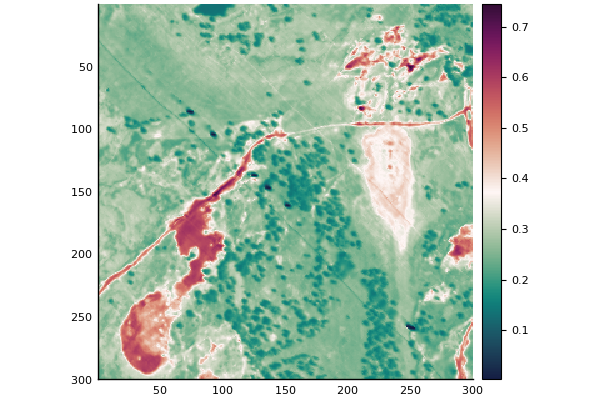

In [5]:
# Visualize a spectral band on its own
p2 = heatmap(img[:,:,150],aspect_ratio=1, yflip = true, c=:curl)

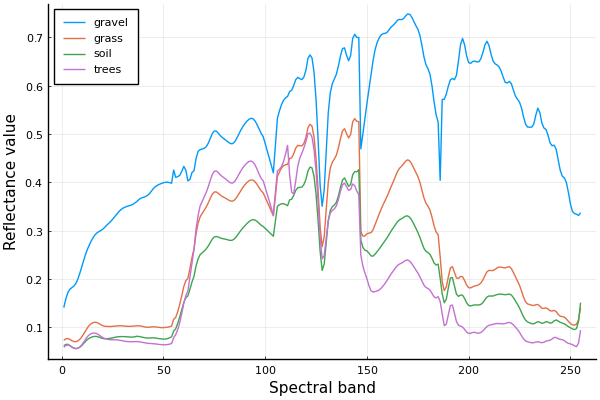

In [6]:
# visualize the endmembers to be used

plot(sources[:,1],label = "gravel")
plot!(sources[:,2],label = "grass")
plot!(sources[:,3],label = "soil")
plot!(sources[:,4],label = "trees")
xlabel!("Spectral band")
ylabel!("Reflectance value")

## Unmixing the image

The model we are using to decompose the image into the sum of the contributions of the endmembers is:

\begin{equation*}
\mathbf{X} = \mathbf{S}\mathbf{A} + \mathbf{E} 
\end{equation*}

 $\mathbf{X}\in \mathbb{R}^{L\times N}$ : data matrix
 
 $\mathbf{S}\in \mathbb{R}^{L\times P}$ : endmember matrix
 
 $\mathbf{A}\in \mathbb{R}^{P\times N}$ : abundance matrix
 
 $\mathbf{E}\in \mathbb{R}^{L\times N}$ : additive noise matrix
 
 where $L$ is the number of spectral bands, $P$ is the number of materials, and $N$ is the number of pixels
 
 The hyperspectral image is represented as a matrix with $N$ pixels, so the first thing to do is to reshape the image to a big matrix.

We can try and estimate the abundance matrix using a least squares formulation:

\begin{equation*}
\hat{A} = \underset{\mathbf{A}>\mathbf{0}, \mathbf{1}_{P}^T \mathbf{A} = \mathbf{1}_{N}^{T} }{\textrm{arg min}}\frac{1}{2}||\mathbf{X}-\mathbf{SA}||_{F}^{2} = \underset{\mathbf{A}>\mathbf{0}, \mathbf{1}_{P}^T \mathbf{A} = \mathbf{1}_{N}^{T} }{\textrm{arg min}}\frac{1}{2} \sum_{i=1}^{N} ||\mathbf{x}_{n}-\mathbf{S}\mathbf{a}_{n}||_{2}^{2}
\end{equation*}

where $\mathbf{1}_{.}$ is a vector of ones whose size is given in index 

Choose an algorithm to solve the optimization problem, and implement it both in a serial version and a version parallelized across the pixels.

In [7]:
n_runtimes = 3

n = 10^2
p = 4
l = 255
k = floor(Int, sqrt(n))

# Use a small crop of the image first
offset_x = 150
offset_y = 1
img_small = img[offset_x:offset_x + k - 1,offset_y:offset_y + k - 1, :]

X = img_small
S = sources;

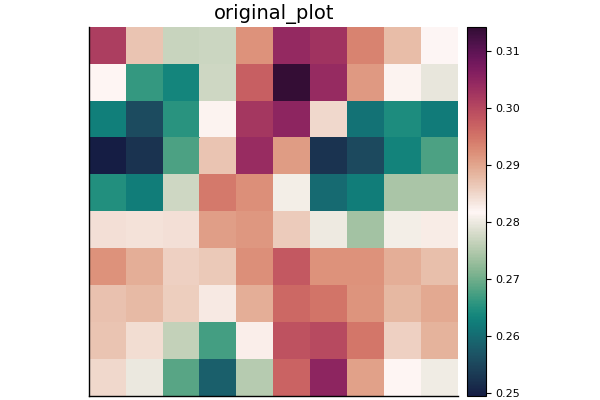

In [8]:
original_plot = heatmap(
    X[:, :, 150], title="original_plot", aspect_ratio=1, yflip = true, c=:curl, grid=false, ticks=false
)

# Serial Projected Gradient (pixel based single constraint)

Add method description ...

In [9]:
new_X_1c, A_1c, mean_loss_1c = estimate_abundance(X, S, "projected_gradient_1c", "serial_pixel");

In [10]:
n_pixels, time_1c = get_runtime_series(X, S, "projected_gradient_1c", "serial_pixel", n_runtimes);

In [11]:
pg_1c_plot = heatmap(
    new_X_1c[:, :, 150], title="projected_gradient_1c", 
    aspect_ratio=1, yflip = true, c=:curl, grid=false, ticks=false, size=(1000, 400)
);
pg_1c_loss = plot(
    log.(mean_loss_1c[mean_loss_1c .> 0]),
    title="Evolution of the log of pixel-mean loss for each iteration",
    ylabel = "Log pixel-mean loss", 
    xlabel = "Number of iteration", 
    label="projected_gradient_1c",
    color="#377eb8"
    
);

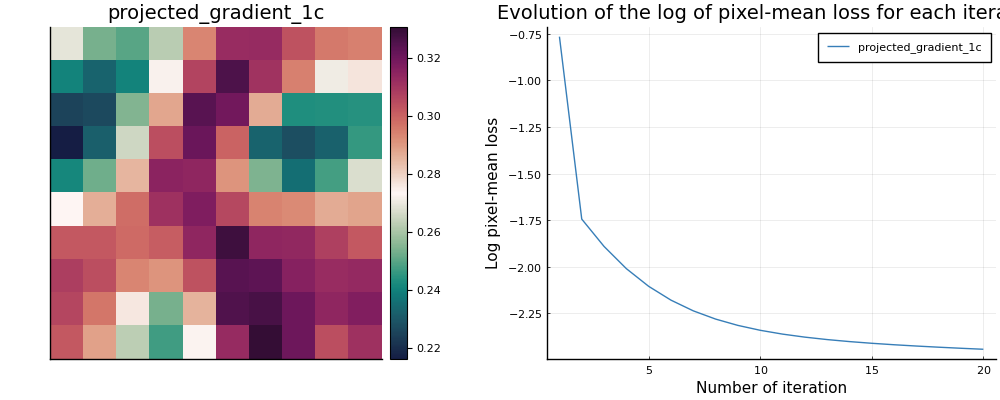

In [12]:
plot(pg_1c_plot, pg_1c_loss, layout=(1, 2), size=(1000, 400))

Add comments ...

# Serial Projected Gradient (pixel based and two constraints)

Add method description ...

In [13]:
new_X_2c, A_2c, mean_loss_2c = estimate_abundance(X, S, "projected_gradient_2c", "serial_pixel");

In [14]:
n_pixels, time_2c = get_runtime_series(X, S, "projected_gradient_2c", "serial_pixel", n_runtimes);

In [15]:
pg_2c_plot = heatmap(
    new_X_2c[:, :, 150], title="projected_gradient_2c", 
    aspect_ratio=1, yflip = true, c=:curl, grid=false, ticks=false, size=(1000, 400)
);
pg_2c_loss = plot(
    log.(mean_loss_2c[mean_loss_2c .> 0]),
    title="Evolution of the log of pixel-mean loss for each iteration",
    ylabel = "Log pixel-mean loss", 
    xlabel = "Number of iteration", 
    label="projected_gradient_2c",
    color="#e41a1c"
);

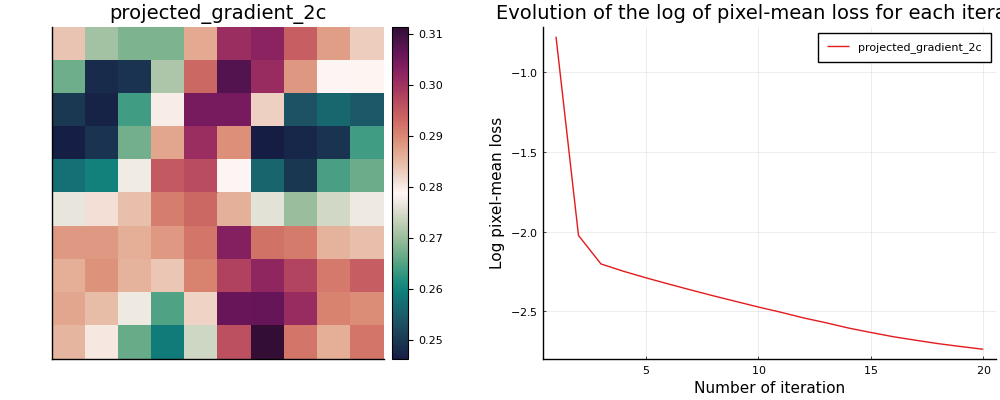

In [16]:
plot(pg_2c_plot, pg_2c_loss, layout=(1, 2), size=(1000, 400))

Add comments ...

# Serial Log-barrier (pixel based)

Add method description ...

In [17]:
new_X_lb, A_lb, mean_loss_lb = estimate_abundance(X, S, "log_barrier", "serial_pixel");

In [18]:
n_pixels, time_lb = get_runtime_series(X, S, "log_barrier", "serial_pixel", n_runtimes);

In [19]:
lb_plot = heatmap(
    new_X_lb[:, :, 150], title="log_barrier", 
    aspect_ratio=1, yflip = true,c=:curl, grid=false, ticks=false, size=(1000, 400)
);
lb_loss = plot(
    log.(mean_loss_lb[mean_loss_lb .> 0]),
    title="Evolution of the log of pixel-mean loss for each iteration",
    ylabel = "Log pixel-mean loss", 
    xlabel = "Number of iteration",
    label="log_barrier",
    color="#4daf4a"
);

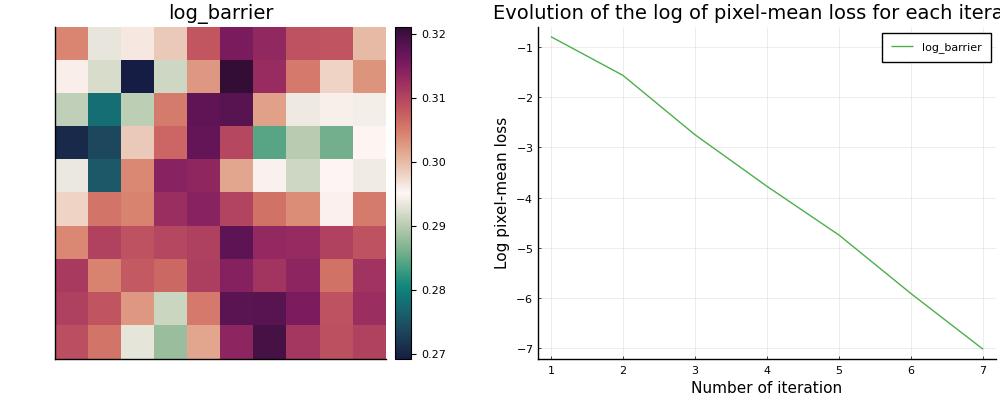

In [20]:
plot(lb_plot, lb_loss, layout=(1, 2), size=(1000, 400))

Add comments ...

# Serial Interior Point Least Square (image-based)

Add method description ...

In [21]:
new_X_ipls, A_ipls, loss_ipls = estimate_abundance(X, S, "ipls", "serial_image");

In [22]:
n_pixels, time_ipls = get_runtime_series(X, S, "ipls", "serial_image", n_runtimes);

In [23]:
ipls_plot = heatmap(
    new_X_ipls[:, :, 150], title="ipls", 
    aspect_ratio=1, yflip = true,c=:curl, grid=false, ticks=false, size=(1000, 400)
);
ipls_loss = plot(
    log.(loss_ipls[loss_ipls .> 0]),
    title="Evolution of the log of pixel-mean loss for each iteration",
    ylabel = "Log pixel-mean loss", 
    xlabel = "Number of iteration",
    label="ipls",
    color="#984ea3"
);

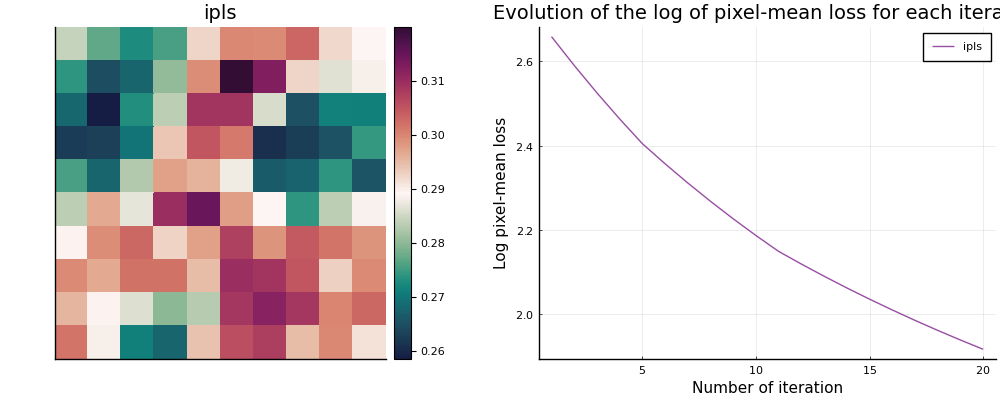

In [24]:
plot(ipls_plot, ipls_loss, layout=(1, 2), size=(1000, 400))

#### We consider here the case of an image based approach where the unmixing will be done on the complete image without iterating on pixels. To do so, we mainly used primal-dual interior point techniques discussed in the following paper [1]. 
#### Also, the algorithm is vectorized in a way that for an (n,p) matrix, we consider the associated reshaped vecteur constituted of n*p lines.
#### The algorithm estimates at the same time the abundance matrix and the Lagrange multipliers. The corresponding directions are found using Newton algorithm. At each iteration, the respect of the constraint is ensured by adding a logarithmic barrier function making the criterion unbounded at the boundary of the feasible solution domain.
#### A backtracking using line search with Armijo condition is applied to find the optimal stepsize at each descent. Finally, and in order to ensure convergence, we ensure that KKT conditions are fulfilled at each step by updating the perturbations.
#### The results shows good performance in terms of the reconstitution of the original image and the plot above shows a decreasing loss at each time step.

# Serial Interior Point Primal-Dual (image-based)

Add method description ...

In [25]:
new_X_primaldual, A_primaldual, loss_primaldual = estimate_abundance(X, S, "primal_dual", "serial_image");

In [26]:
n_pixels, time_primaldual = get_runtime_series(X, S, "primal_dual", "serial_image", n_runtimes);

In [27]:
primaldual_plot = heatmap(
    new_X_primaldual[:, :, 150], title="primal_dual", 
    aspect_ratio=1, yflip = true,c=:curl, grid=false, ticks=false, size=(1000, 400)
);
primaldual_loss = plot(
    log.(loss_primaldual[loss_primaldual .> 0]),
    title="Evolution of the log of pixel-mean loss for each iteration",
    ylabel = "Log pixel-mean loss", 
    xlabel = "Number of iteration",
    label="primal_dual",
    color="#ff7f00"
);

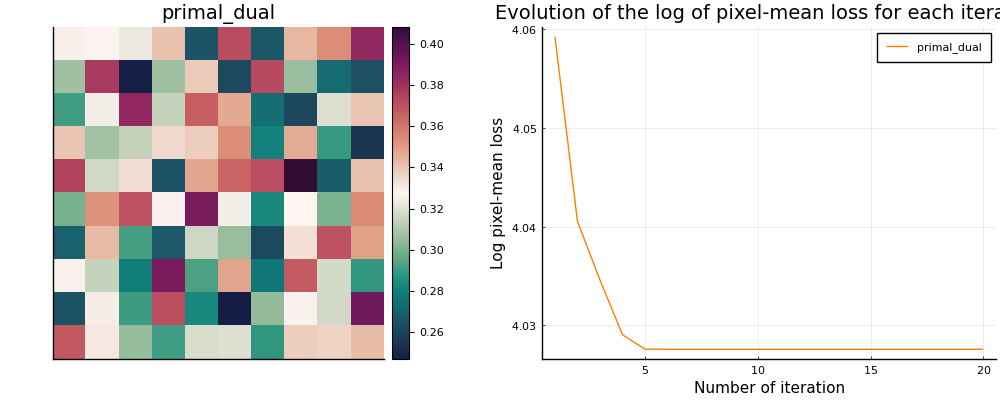

In [28]:
plot(primaldual_plot, primaldual_loss, layout=(1, 2), size=(1000, 400))

Add comments ...

# Parallel Log-barrier (pixel based)

Add method description ...

In [29]:
time_series_parallel = Dict()
X_parallel_lb = Dict()
for i=1:3
    addprocs(i)
    @everywhere include("./unmixing_optimization/main.jl")
    n_pixels, time_series_parallel[i+1] = get_runtime_series(X, S, "log_barrier","parallel_pixel", n_runtimes)
    X_parallel_lb[i+1], _, _ = estimate_abundance(X, S, "log_barrier", "parallel_pixel");
end;

In [30]:
parallel_lb_4_plot = heatmap(
    X_parallel_lb[4][:, :, 150], title="parallel_4_log_barrier", 
    aspect_ratio=1, yflip = true, c=:curl, grid=false, ticks=false
);

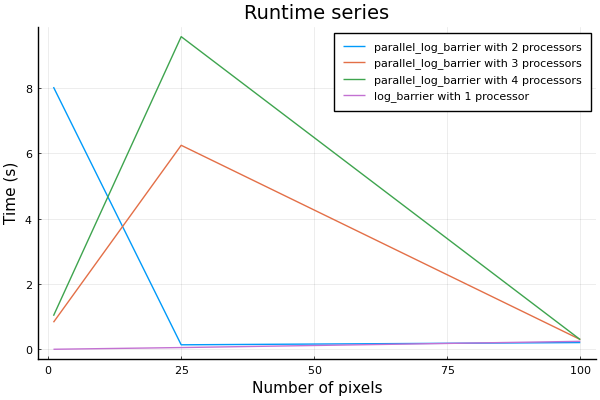

In [31]:
n_pixels2 = [k^2 for k = n_pixels]

plot()

for i=1:length(time_series_parallel)
    plot!(
        n_pixels2, time_series_parallel[i+1],
        title="Runtime series",
        ylabel = "Time (s)", 
        xlabel = "Number of pixels", 
        label=string("parallel_log_barrier with ",string(i+1)," processors")
    )
end


plot!(n_pixels2, time_lb,
    label="log_barrier with 1 processor",
    ylabel = "Time (s)", 
    xlabel = "Number of pixels", 
)


Add comments ...

# Model Comparison

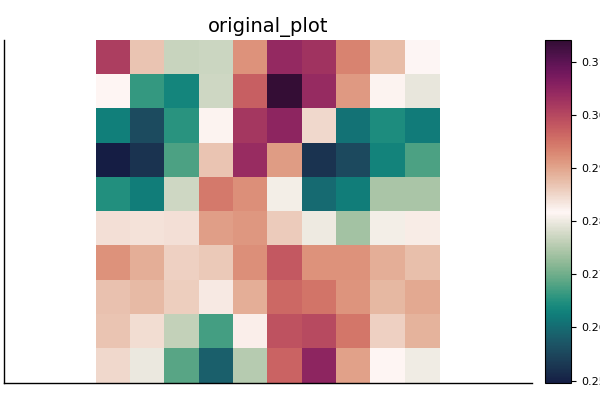

In [32]:
plot(original_plot)

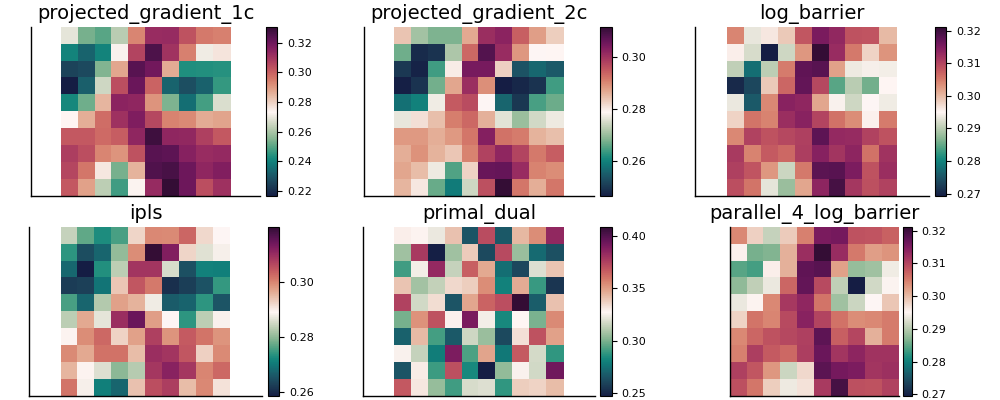

In [33]:
p = plot(
    pg_1c_plot, pg_2c_plot, lb_plot, ipls_plot, primaldual_plot, parallel_lb_4_plot, 
    layout=(2, 3), size=(1000, 400)
)

Add comments ...

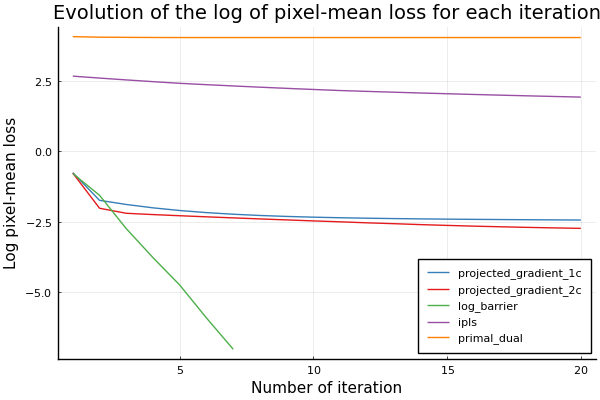

In [34]:
plot(
    log.(mean_loss_1c[mean_loss_1c .> 0]),
    title="Evolution of the log of pixel-mean loss for each iteration",
    ylabel = "Log pixel-mean loss", 
    xlabel = "Number of iteration", 
    label="projected_gradient_1c",
    color="#377eb8"
    
)
plot!(
    log.(mean_loss_2c[mean_loss_2c .> 0]),
    label="projected_gradient_2c",
    color="#e41a1c"
)
plot!(
    log.(mean_loss_lb[mean_loss_lb .> 0]),
    label="log_barrier",
    color="#4daf4a"
)
plot!(
    log.(loss_ipls[loss_ipls .> 0]),
    label="ipls",
    color="#984ea3"
)
plot!(
    log.(loss_primaldual[loss_primaldual .> 0]),
    label="primal_dual",
    color="#ff7f00"
)

Add comments ...

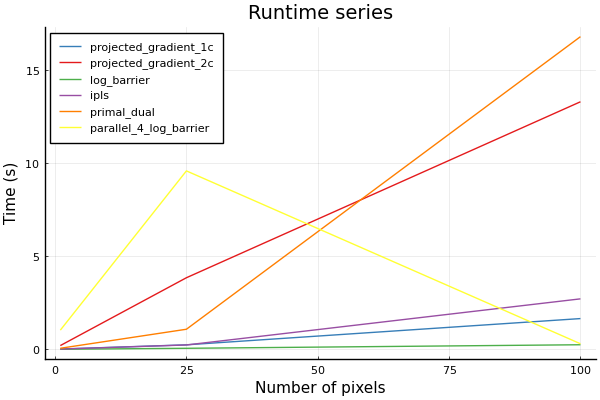

In [35]:
n_pixels2 = [k^2 for k = n_pixels]
plot(
    n_pixels2, time_1c,
    title="Runtime series",
    ylabel = "Time (s)", 
    xlabel = "Number of pixels", 
    label="projected_gradient_1c",
    color="#377eb8"
    
)
plot!(
    n_pixels2, time_2c,
    label="projected_gradient_2c",
    color="#e41a1c"
)
plot!(
    n_pixels2, time_lb,
    label="log_barrier",
    color="#4daf4a"
)
plot!(
    n_pixels2, time_ipls,
    label="ipls",
    color="#984ea3"
)
plot!(
    n_pixels2, time_primaldual,
    label="primal_dual",
    color="#ff7f00"
)
plot!(
    n_pixels2, time_series_parallel[4],
    label="parallel_4_log_barrier",
    color="#ffff33"
)

Add comments ...

# References

[1] https://hal.archives-ouvertes.fr/hal-00828013/document <br>
[2] ...